<a href="https://colab.research.google.com/github/n1az/dog-vision-ai/blob/main/dog_vision.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# End-to-end MuMulti-class Dog Bread Classification

This notebook builds an end-to-end multi-class image classifier using TensorFlow 2.0 and TensorFlow Hub.

## 1. Problem

Identifying the bread of a dog given an image of dogs.

When I'm sitting at the cafe and I take a photo of a dog, I want to know what breed it is.

## 2. Data

The data we are using is from Kaggle's dog breed identification competetion.

## 3. Evaluation

The evaluation is a file prediction probabilities for each dog breed of each test image.

https://www.kaggle.com/c/dog-breed-identification/overview/evaluation

## 4. Features

Some information about the data:
* We're dealing with images (unstructured data) so it's probably best we use deep learning/transfer learning.
* There are 120 breeds of dogs.
* There are around 10000+ images in the training set. ( These images have labels).
* There are around 10000+ images in the test set. ( these images have no labels, because we'll want to predict them)


### Get our workspace ready

* Import TensorFlow 2.x
* Import TensorFlow Hub
* Make sure we're using a GPU

In [ ]:
# Import TensorFlow into Colab
import tensorflow as tf
print("TF version:", tf.__version__)

TF version: 2.5.0


In [ ]:
# Import TensorFlow Hub
import tensorflow_hub as hub
print("TF Hub version:", hub.__version__)

# Check for GPU avaialability
print("GPU", "available (YESSS!!)" if tf.config.list_physical_devices("GPU") else "not available :(")

TF Hub version: 0.12.0
GPU available (YESSS!!)


## Getting our data ready (turning into Tensors)

With all machine learning models, our data has to be in numerical format. So that's what we'll be doing first. Turning our images into Tensors (numerical representations).

Let's start by accessing our data and checking out the labels.

In [ ]:
# Checkout the lables of our data
import pandas as pd
labels_csv = pd.read_csv("drive/MyDrive/MLPROJECT/DOG_VISON/labels.csv")
print(labels_csv.describe())
print(labels_csv.head())

                                      id               breed
count                              10222               10222
unique                             10222                 120
top     b3d40aabb2e2514c0443d7d91c5c6696  scottish_deerhound
freq                                   1                 126
                                 id             breed
0  000bec180eb18c7604dcecc8fe0dba07       boston_bull
1  001513dfcb2ffafc82cccf4d8bbaba97             dingo
2  001cdf01b096e06d78e9e5112d419397          pekinese
3  00214f311d5d2247d5dfe4fe24b2303d          bluetick
4  0021f9ceb3235effd7fcde7f7538ed62  golden_retriever


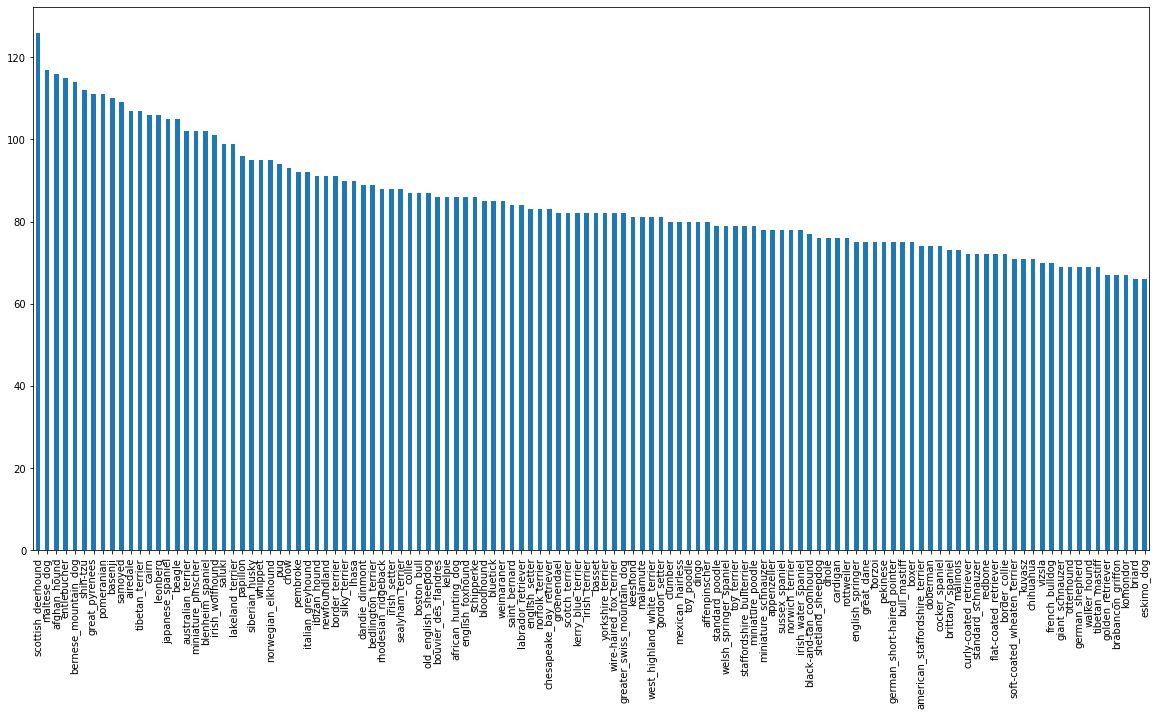

In [ ]:
# How many images are there of each breed?
labels_csv["breed"].value_counts().plot.bar(figsize=(20,10))

In [ ]:
labels_csv["breed"].value_counts().median()

82.0

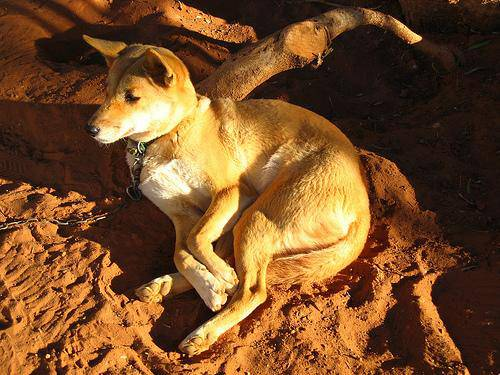

In [ ]:
# Let's view an image
from IPython.display import Image
Image("drive/MyDrive/MLPROJECT/DOG_VISON/train/001513dfcb2ffafc82cccf4d8bbaba97.jpg")

### Getting images and thier labels

Let's get a list of all of our image file pathnames.

In [ ]:
# Create pathnames from image ID's
filenames = ["drive/MyDrive/MLPROJECT/DOG_VISON/train/" + fname + ".jpg" for fname in labels_csv["id"]]

# Check the first 5
filenames[:5]

['drive/MyDrive/MLPROJECT/DOG_VISON/train/000bec180eb18c7604dcecc8fe0dba07.jpg',
 'drive/MyDrive/MLPROJECT/DOG_VISON/train/001513dfcb2ffafc82cccf4d8bbaba97.jpg',
 'drive/MyDrive/MLPROJECT/DOG_VISON/train/001cdf01b096e06d78e9e5112d419397.jpg',
 'drive/MyDrive/MLPROJECT/DOG_VISON/train/00214f311d5d2247d5dfe4fe24b2303d.jpg',
 'drive/MyDrive/MLPROJECT/DOG_VISON/train/0021f9ceb3235effd7fcde7f7538ed62.jpg']

In [ ]:
# Check whether number of filenames matches number of actual image files
import os
if len(os.listdir("drive/MyDrive/MLPROJECT/DOG_VISON/train/")) == len(filenames):
  print("Proceed")
else:
  print("Numbers not matched")

Proceed


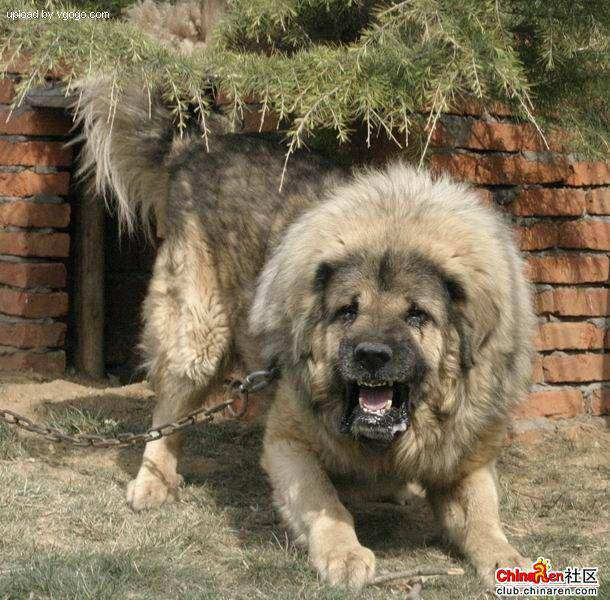

In [ ]:
Image(filenames[9000])

In [ ]:
labels_csv["breed"][9000]

'tibetan_mastiff'

Since we've now got our training image filepath in a list, let's prepare our labels.

In [ ]:
import numpy as np
labels = labels_csv["breed"].to_numpy()
# labels = np.array(labels) # does same thing as above
labels

array(['boston_bull', 'dingo', 'pekinese', ..., 'airedale',
       'miniature_pinscher', 'chesapeake_bay_retriever'], dtype=object)

In [ ]:
len(labels)

10222

In [ ]:
## See if number of labels matches the number of filenames
if len(labels) == len(filenames):
  print("matched")
else:
  print("Not matched")

matched


In [ ]:
# Find the unique label values
unique_breeds = np.unique(labels)
len(unique_breeds)

120

In [ ]:
# Turn a single label into an array of booleans
print(labels[0])
labels[0] == unique_breeds

boston_bull


array([False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False,  True, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False])

In [ ]:
# Turn every label into a boolean array
boolean_labels = [label == unique_breeds for label in labels]
boolean_labels[:2]

[array([False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False,  True, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False]),
 array([False, False, False, False, False, Fal

In [ ]:
len(boolean_labels)

10222

In [ ]:
# Example: Turning boolean array into integers
print(labels[0]) # origin label
print(np.where(unique_breeds == labels[0])) # index where label occurs
print(boolean_labels[0].argmax()) # index where label occurs in boolean array
print(boolean_labels[0].astype(int)) # there will be a 1 where the sample label occurs

boston_bull
(array([19]),)
19
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0]


In [ ]:
print(labels[2])
print(boolean_labels[2].astype(int))

pekinese
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0]


### Creating our own validation set

Since the dataset from kaggle does not come with validation set, we're going to create our own.

In [ ]:
# setup X & y variables
X = filenames
y = boolean_labels

We're going to start off experimenting with ~1000 images and increase as needed.

In [ ]:
# set number of images to use for experimenting
NUM_IMAGES = 1000 #@param {type:"slider", min:1000, max:10000}

In [ ]:
# Let's split our data into train and validation sets
from sklearn.model_selection import train_test_split

# Split them
X_train, X_val, y_train, y_val = train_test_split(X[:NUM_IMAGES],
                                                  y[:NUM_IMAGES],
                                                  test_size=0.2,
                                                  random_state=42)

len(X_train), len(y_train), len(X_val), len(y_val)

(800, 800, 200, 200)

In [ ]:
# Let's see the data
X_train[:5], y_train[:2]

(['drive/MyDrive/MLPROJECT/DOG_VISON/train/00bee065dcec471f26394855c5c2f3de.jpg',
  'drive/MyDrive/MLPROJECT/DOG_VISON/train/0d2f9e12a2611d911d91a339074c8154.jpg',
  'drive/MyDrive/MLPROJECT/DOG_VISON/train/1108e48ce3e2d7d7fb527ae6e40ab486.jpg',
  'drive/MyDrive/MLPROJECT/DOG_VISON/train/0dc3196b4213a2733d7f4bdcd41699d3.jpg',
  'drive/MyDrive/MLPROJECT/DOG_VISON/train/146fbfac6b5b1f0de83a5d0c1b473377.jpg'],
 [array([False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False,  True,
         False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False,
         Fals